In [ ]:
import numpy as np
import pandas as pd

# Definir variables y rango de valores
variables = ['temperatura', 'humedad', 'presion']
rango = {'temperatura': (0, 40), 'humedad': (20, 90), 'presion': (900, 1100)}

# Generar valores aleatorios
dias = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
datos = pd.DataFrame(index=dias, columns=variables)
for variable in variables:
    datos[variable] = np.random.uniform(low=rango[variable][0], high=rango[variable][1], size=len(dias))

# Asignar valores a diferentes momentos del día
datos['mañana'] = datos['temperatura'] - np.random.uniform(low=0, high=10, size=len(dias))
datos['mediodia'] = datos['temperatura'] + np.random.uniform(low=0, high=10, size=len(dias))
datos['noche'] = datos['temperatura'] - np.random.uniform(low=0, high=10, size=len(dias))

# Agregar ruido
for variable in variables:
    datos[variable] = datos[variable] + np.random.normal(loc=0, scale=1, size=len(dias))

# Almacenar los datos
datos.to_csv('datos_sinteticos.csv', index_label='fecha')


In [ ]:
print(datos.shape[0])


365


In [ ]:
print(datos.head)

<bound method NDFrame.head of             temperatura    humedad      presion     mañana   mediodia  \
2023-01-01     8.711614  30.118891  1084.635668  -2.211120  10.429692   
2023-01-02    23.563730  54.324001  1060.044774  21.982251  26.690331   
2023-01-03    18.922497  33.970791  1043.655917  18.085529  27.680262   
2023-01-04     3.340378  44.129742   924.106673  -2.128701   6.001928   
2023-01-05    26.604857  64.546677  1049.505810  16.134282  29.561303   
...                 ...        ...          ...        ...        ...   
2023-12-27    30.410855  85.457915  1018.339384  30.143629  34.468551   
2023-12-28    34.227298  22.152554  1008.198194  33.915668  38.558404   
2023-12-29    22.334709  72.934213   979.297650  15.213826  27.968543   
2023-12-30     1.027274  39.416139   979.717318  -5.296435   4.897871   
2023-12-31    36.274786  79.721140  1014.101155  34.334366  45.424051   

                noche  
2023-01-01   0.253102  
2023-01-02  15.126119  
2023-01-03  16.355687

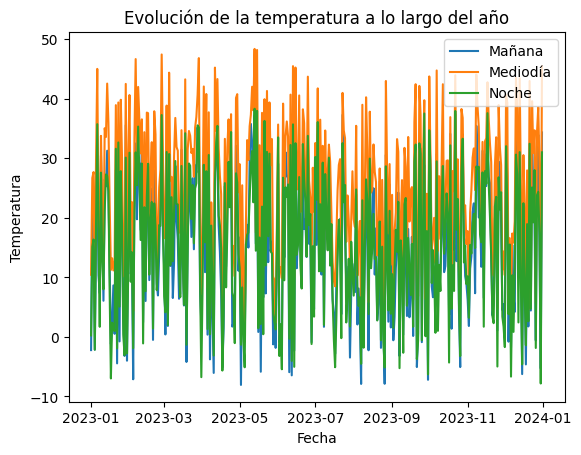

In [ ]:
import matplotlib.pyplot as plt

# Crear figura y ejes
fig, ax = plt.subplots()

# Graficar temperatura en la mañana, mediodía y noche
ax.plot(datos.index, datos['mañana'], label='Mañana')
ax.plot(datos.index, datos['mediodia'], label='Mediodía')
ax.plot(datos.index, datos['noche'], label='Noche')

# Configurar el gráfico
ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura')
ax.set_title('Evolución de la temperatura a lo largo del año')
ax.legend()

# Mostrar el gráfico
plt.show()


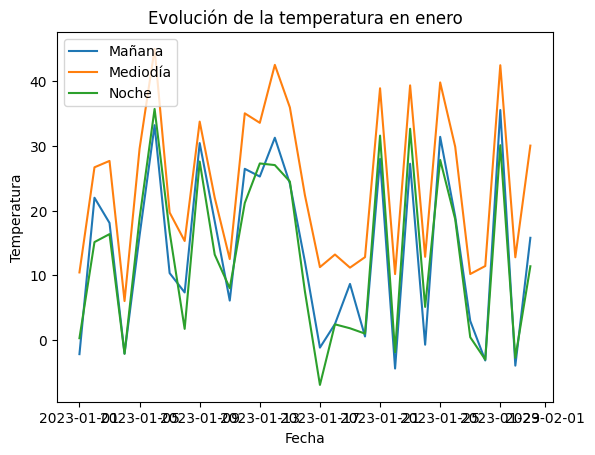

In [ ]:
import matplotlib.pyplot as plt

# Seleccionar datos de enero
datos_enero = datos.loc['2023-01-01':'2023-01-31']

# Crear figura y ejes
fig, ax = plt.subplots()

# Graficar temperatura en la mañana, mediodía y noche
ax.plot(datos_enero.index, datos_enero['mañana'], label='Mañana')
ax.plot(datos_enero.index, datos_enero['mediodia'], label='Mediodía')
ax.plot(datos_enero.index, datos_enero['noche'], label='Noche')

# Configurar el gráfico
ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura')
ax.set_title('Evolución de la temperatura en enero')
ax.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("datos_sinteticos.csv", usecols=lambda x: x != 'fecha')

data = df.values.astype(np.float32)

input_cols = ['mañana', 'mediodia', 'noche']
output_cols = ['temperatura']
# separar los datos de entrada y salida
X = data[:, :len(input_cols)]
y = data[:, -len(output_cols):]


# dividir los datos en entrenamiento, validación y prueba
train_size = int(0.6 * len(X))
valid_size = int(0.2 * len(X))
test_size = len(X) - train_size - valid_size

X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size+valid_size], y[train_size:train_size+valid_size]
X_test, y_test = X[train_size+valid_size:], y[train_size+valid_size:]

y_train = y_train.reshape(-1, 1, 1)
y_valid = y_valid.reshape(-1, 1, 1)
y_test = y_test.reshape(-1, 1, 1)


dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}



In [ ]:
X.shape

(365, 3)

In [ ]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=3, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
    x_reshaped = x.contiguous().view(-1, x.size(-1))
    y = self.fc(x_reshaped)
    # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
    y = y.contiguous().view(x.size(0), -1, y.size(-1))
    return y

In [ ]:
class BidirectionalRNN(DeepRNN):
    def __init__(self, n_out=1, dropout=0, bidirectional=False):
        super().__init__()
        self.rnn = torch.nn.GRU(input_size=3, hidden_size=20, num_layers=5, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        if bidirectional:
            self.fc = torch.nn.Linear(2*20, n_out)
        else:
            self.fc = torch.nn.Linear(20, n_out)

gru = BidirectionalRNN()


In [ ]:
# parámetros en inputs (W_ir|W_iz|W_in)
# 3 matrices, 1 para cada *gate* 

gru.rnn.weight_ih_l0.shape

torch.Size([60, 3])

In [ ]:
gru.rnn.weight_hh_l0.shape

torch.Size([60, 20])

In [ ]:
# Crear objeto de modelo BidirectionalRNN
model = BidirectionalRNN()

# Salida y capas ocultas (short term y long term)
output, h = model.rnn(torch.randn(10, 50, 3))

# Dims -> [num_layers*num_directions, batch_size, hidden_size]
h.shape


torch.Size([5, 10, 20])

In [ ]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        train_loss2 = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        model.eval()
        eval_loss = []
        eval_loss2 = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                eval_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")

def predict(model, dataloader):
    model.eval() 
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds



gru = BidirectionalRNN()
fit(gru, dataloader)

loss 145.61869 loss_last_step 145.61869 val_loss 129.16920 val_loss_last_step 129.16920: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


In [ ]:
from sklearn.metrics import mean_squared_error

# hacer predicciones en el conjunto de pruebas
y_pred = predict(gru, dataloader['test'])

mse = mean_squared_error(y_test[:,-1], y_pred[:,-1].cpu())

print(f"MSE en el conjunto de pruebas: {mse:.4f}")

MSE en el conjunto de pruebas: 139.3239


In [ ]:
print(model)

BidirectionalRNN(
  (rnn): GRU(3, 20, num_layers=5, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)
